In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings('ignore')

def parse_line(line):
    parsed_line = tf.strings.split(line, ',')
    features = tf.strings.to_number(parsed_line[:-1], out_type=tf.float32)
    labels = tf.strings.to_number(parsed_line[-1], out_type=tf.float32)
    return features, labels

# Skiping first 8 lines
skip_rows = 8
file_path = "F:\\Aidin\\Universities\\Amirkabir (Master)\\Lessons\\Term-1\\Neural-Computing & Deep-Learning\\Projects\\My-Answers\\HW1\\data.txt"
dataset = tf.data.TextLineDataset(file_path).skip(skip_rows)
dataset = dataset.map(parse_line)

# Printing the head of dataset that have been read
print(f"{'X1':>10} {'X2':>10} {'Label':>10}")
for features, label in dataset.take(5):
    x1, x2 = features.numpy()
    print(f"{x1:>10.6f} {x2:>10.6f} {label.numpy():>10}")


C:\Program Files\Anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


        X1         X2      Label
  4.780310   2.698320        0.0
 -2.273710   5.750180        0.0
 -4.817170  -2.209610        0.0
 -9.526940   0.659360        0.0
  1.864400  -5.019510        0.0


In [2]:
total_samples = 0
for _ in dataset:
    total_samples += 1
train_size = int(0.7 * total_samples)
test_size = int(0.2 * total_samples)
validation_size = total_samples - train_size - test_size
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size).take(test_size)
validation_dataset = dataset.skip(train_size + test_size)
print(f"Total samples: {total_samples}, Training samples: {train_size}, Test samples: {test_size}, Validation samples: {validation_size}")

Total samples: 4500, Training samples: 3150, Test samples: 900, Validation samples: 450


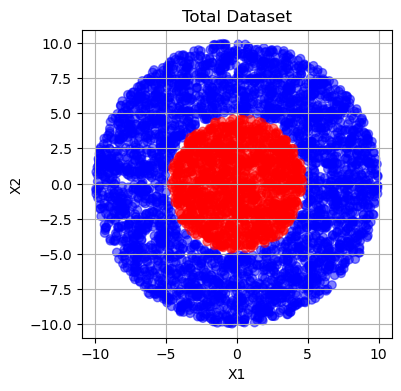

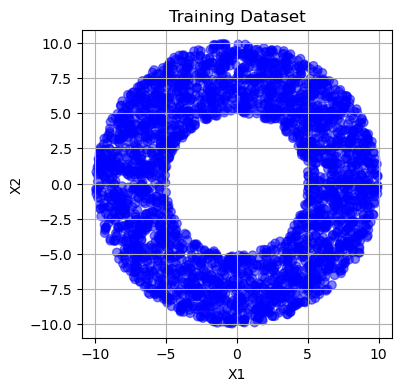

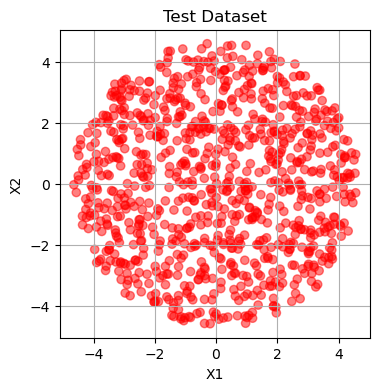

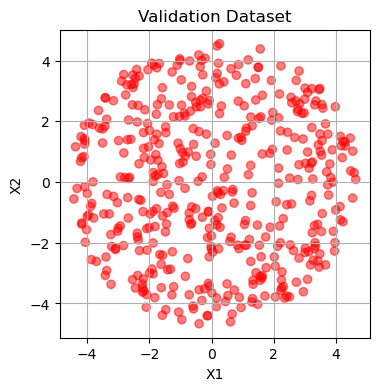

In [3]:
def plot_dataset(dataset, title="Dataset"):
    x, y, color = [], [], []
    for features, label in dataset:
        x1, x2 = features.numpy()
        x.append(x1)
        y.append(x2)
        color.append('blue' if label.numpy() == 0 else 'red')  
    plt.figure(figsize=(4, 4))
    plt.scatter(x, y, c=color, alpha=0.5)
    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.grid(True)
    plt.show()

plot_dataset(dataset, "Total Dataset")
plot_dataset(train_dataset, "Training Dataset")
plot_dataset(test_dataset, "Test Dataset")
plot_dataset(validation_dataset, "Validation Dataset")


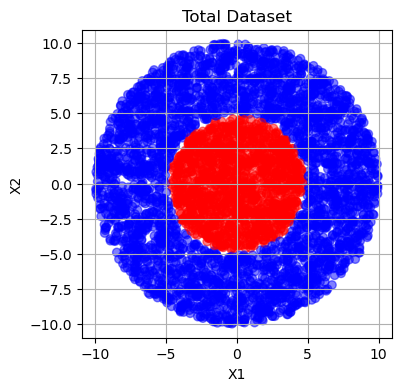

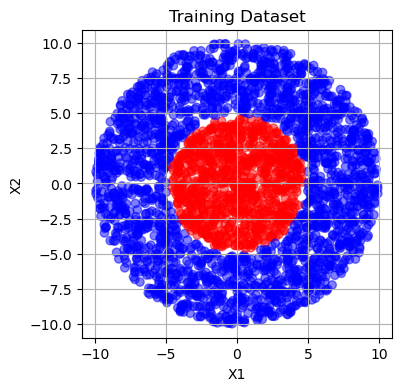

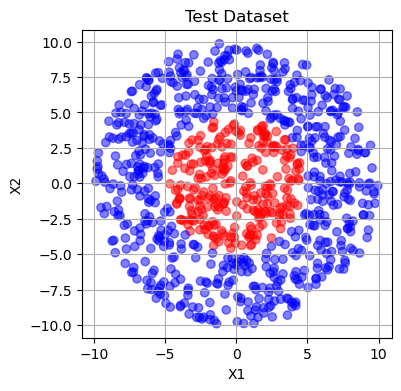

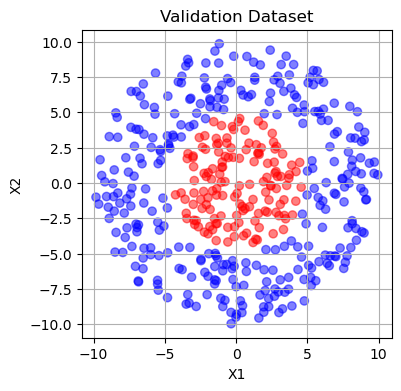

In [4]:
dataset = dataset.shuffle(buffer_size=total_samples)
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size).take(test_size)
validation_dataset = dataset.skip(train_size + test_size)
plot_dataset(dataset, "Total Dataset")
plot_dataset(train_dataset, "Training Dataset")
plot_dataset(test_dataset, "Test Dataset")
plot_dataset(validation_dataset, "Validation Dataset")

In [10]:
def calculate_f1_score(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(int)
    true_positives = np.sum((y_pred_binary == 1) & (y_true == 1))
    predicted_positives = np.sum(y_pred_binary == 1)
    actual_positives = np.sum(y_true == 1)
    precision = true_positives / (predicted_positives + 1e-7)
    recall = true_positives / (actual_positives + 1e-7)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
    return f1_score

model = tf.keras.Sequential([tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(2,))])
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])


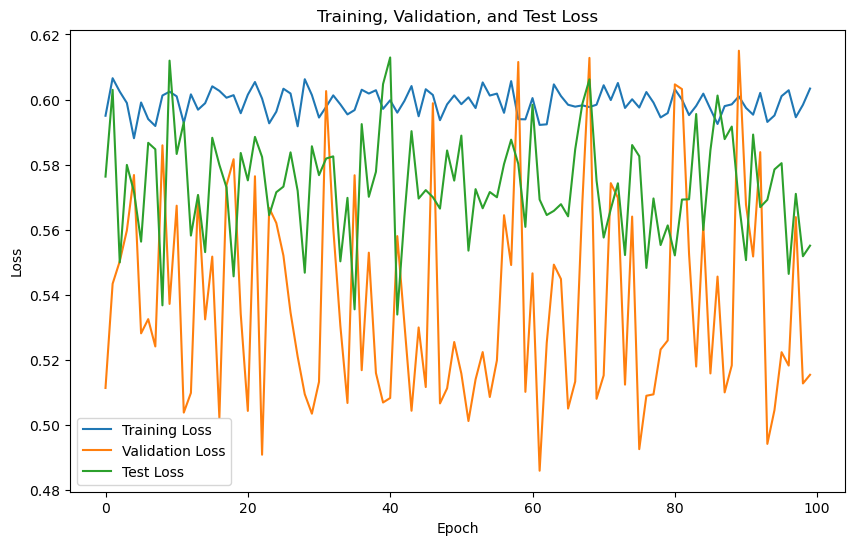

In [29]:
epochs = 100
train_loss_history = []
validation_loss_history = []
test_loss_history = []

for epoch in range(epochs):
    history = model.fit(train_dataset.batch(64), epochs=1, verbose=0, validation_data=validation_dataset.batch(64))
    train_loss_history.append(history.history['loss'][0])
    validation_loss_history.append(history.history['val_loss'][0])
    test_loss, *_ = model.evaluate(test_dataset.batch(64), verbose=0)
    test_loss_history.append(test_loss)

plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(validation_loss_history, label='Validation Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

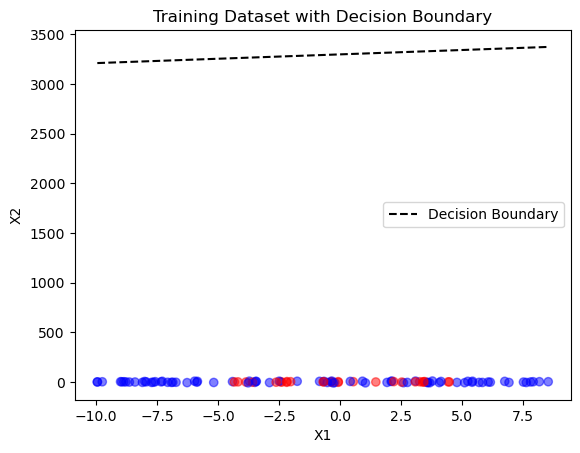

In [30]:
x1s, x2s, colors = [], [], []
for features, label in train_dataset.take(100): 
    x1, x2 = features.numpy()
    x1s.append(x1)
    x2s.append(x2)
    colors.append('blue' if label.numpy() == 0 else 'red')
plt.scatter(x1s, x2s, c=colors, alpha=0.5)
plt.title("Training Dataset with Decision Boundary")
plt.xlabel("X1")
plt.ylabel("X2")
weights, bias = model.layers[0].get_weights()
w1, w2 = weights[0], weights[1]
b = bias[0]
x1_values = np.linspace(min(x1s), max(x1s), 100)
x2_values = -(b + w1 * x1_values) / w2
plt.plot(x1_values, x2_values, 'k--', label='Decision Boundary')
plt.legend()
plt.show()


In [24]:
test_dataset_batch = test_dataset.batch(32)
y_true = np.concatenate([y.numpy() for _, y in test_dataset_batch])
y_pred_prob = model.predict(test_dataset_batch)
y_pred_binary = (y_pred_prob > 0.5).astype(int)
f1 = calculate_f1_score(y_true, y_pred_binary)
print(f"F1-Score: {f1}")
accuracy_0 = np.sum((y_pred_binary == 0) & (y_true == 0)) / np.sum(y_true == 0)
accuracy_1 = np.sum((y_pred_binary == 1) & (y_true == 1)) / np.sum(y_true == 1)
print(f"Accuracy for class 0: {accuracy_0:.4f}")
print(f"Accuracy for class 1: {accuracy_1:.4f}")
print(f"Weights: {weights.flatten()}")
print(f"Bias: {bias}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
F1-Score: 0.0
Accuracy for class 0: 900.0000
Accuracy for class 1: 0.0000
Weights: [-0.00039228 -0.02011534]
Bias: [-0.8475573]
